<h3> <p> COMPLEX Feature Engineering and Finding the Best Prediction Model for </p>
    <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview"> 
        House Prices: Advanced Regression Techniques </a>  data set </h3>
        
<p> This Notebook was using: </p>
<p> Notebook 6.0.3, Python 3.7.7, scikit-learn 0.23.1, xgboost 1.1.0, numpy 1.18.1, pandas 1.0.3 </p>

<h4> This more complex approach resulted in root mean logarithmic error of 0.1158 </h4> 


Firstly, function read_data is defined. This function will: 
<p> 1) Read dataset </p>
<p> 2) Mapp nan-values which are not missing at random but they mean that the house does not have that feature </p>
(based on data description available with the data set) </p>
<p> 3) Mapp Excellent, Good etc. to numbers for consistency</p>
<p> 4) Create engineered features (careful plotting was done before deciding on these features) </p>
<p> 5) Separate features into: </p>
<p> categorical, nominal and continuous. </p>
<p> 6) Impute nan values depending on if a feature category. </p>
<p> KNNImputer is used for ordinal and continuous features, while for nominal features missing values are treated as missing not at random and added as extra value before OneHotImputer is used. 
<p> 7) Do log transform for continuous features. </p>
<p> 8) Standard rescale ordinal and continuous features.</p>

In [1]:
'''
Define a function read_data that will 
1) read dataset 
2) Mapp nan-values which are not missing at random but they mean that the house does not have that feature 
(based on data description available with the data set) 
3) Mapp Excellent, Good etc. to numbers for consistency
4) Create engineered features (careful plotting was done before deciding on these features) 
5) Separate features into: 
categorical, nominal and continuous. 
6) Impute nan values depending on if a feature category. 
7) Do log transform for continuous features 
8) Standard rescale ordinal and continuous features
'''

def read_data():
    
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer, KNNImputer
    import seaborn as sns
    
    #------------ READ DATA -----------------
    Data_all_train = pd.read_csv("train.csv")
    Data_all_test = pd.read_csv("test.csv")
    
    df_Data_test = Data_all_test.iloc[:, 1:]
    df_Data_train = Data_all_train.iloc[:,1:-1]
    y = Data_all_train.iloc[:, -1].values
    
    train_location = df_Data_train.shape[0]
    
    #--- join test and tran set for presprocessing --------
    df_Data = pd.concat([df_Data_train, df_Data_test], axis=0)
    df_Data = df_Data.reset_index()  

  
    # ------- MAPING NAN VALUES WITH THEIR MEANING  -----------------------------
    

    maping_function = { np.nan: 'Not_Having'}
    df_Data['Alley'] = df_Data['Alley'].replace(maping_function)
    df_Data['GarageType'] = df_Data['GarageType'].replace(maping_function)
    df_Data['Fence'] = df_Data['Fence'].replace(maping_function)
    df_Data['MiscFeature'] = df_Data['MiscFeature'].replace(maping_function)
    
    
    #-------------- MAPPING THE ORDINAL FEATURES --------------------
    
    maping_function = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0}     
        
    df_Data['ExterCond'] = df_Data['ExterCond'].replace(maping_function)
    df_Data['ExterQual'] = df_Data['ExterQual'].replace(maping_function)
    
    df_Data['BsmtQual'] = df_Data['BsmtQual'].replace(maping_function)
    df_Data['BsmtCond'] = df_Data['BsmtCond'].replace(maping_function)
    
    df_Data['GarageQual'] = df_Data['GarageQual'].replace(maping_function)
    df_Data['GarageCond'] = df_Data['GarageCond'].replace(maping_function)
    
    df_Data['HeatingQC'] = df_Data['HeatingQC'].replace(maping_function)
    df_Data['KitchenQual'] = df_Data['KitchenQual'].replace(maping_function)
    
    df_Data['PoolQC'] = df_Data['PoolQC'].replace(maping_function)
    
    df_Data['FireplaceQu'] = df_Data['FireplaceQu'].replace(maping_function) 
    
    maping_function = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0}
    df_Data['BsmtExposure'] = df_Data['BsmtExposure'].replace(maping_function)
       
    maping_function = {'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0}
    df_Data['GarageFinish'] = df_Data['GarageFinish'].replace(maping_function)
    
 
    
    #--------- INGENEERED FEATURES --------------------------
   
    #--- (Quality+Condition)^2 is a new variable that is linear-ish with Price -------
    New_ax = np.square(df_Data[['OverallQual', 'OverallCond']].sum(axis=1))    
    New_ax = np.array(New_ax)
    New_ax[New_ax<40.0] = 40.0   
    df_Data = df_Data.drop(['OverallQual', 'OverallCond'], axis=1)
    df_Data = df_Data.assign(Overall_QualCond = New_ax)
    
    New_ax = np.square(df_Data[['ExterCond', 'ExterQual']].sum(axis=1))   
    New_ax = np.array(New_ax)
    New_ax[New_ax > 64.0] = 64.0    
    df_Data = df_Data.drop(['ExterCond', 'ExterQual'], axis=1)
    df_Data = df_Data.assign(Exter_QualCond = New_ax)
    
    New_ax = np.square(df_Data[['BsmtQual', 'BsmtCond']].sum(axis=1))   
    New_ax = np.array(New_ax)
    New_ax[New_ax > 64.0] = 64.0  
    df_Data = df_Data.drop(['BsmtQual', 'BsmtCond'], axis=1)
    df_Data = df_Data.assign(Bsmt_QualCond = New_ax) #Zero indicates there was no Basment
    
    New_ax = np.square(df_Data[['GarageQual', 'GarageCond']].sum(axis=1))   
    New_ax = np.array(New_ax) 
    df_Data = df_Data.drop(['GarageQual', 'GarageCond'], axis=1)
    df_Data = df_Data.assign(Garage_QualCond = New_ax) #Zero indicates there was no Basment
    
    #Set minimum of of GarageArea from 0 to 170 so that the data is more linear with price
    maping_function = {0: 170}
    df_Data['GarageArea'] = df_Data['GarageArea'].replace(maping_function)
    
 
    #------------Total living Area minus low quality area -------------------
    df_Data['GrLivArea_Quality'] = df_Data['GrLivArea'] - df_Data['LowQualFinSF'] 
 
     #----- Total Num of Bathrooms --------
    df_Data['TotalBath'] = df_Data["FullBath"]  + 0.5 * df_Data["HalfBath"]
    df_Data['TotalBath_Bsmt'] =  df_Data["BsmtFullBath"] + 0.5 * df_Data["BsmtHalfBath"]
       
    #------- House area + Basment area ----------------
    df_Data['TotalSF'] = df_Data["GrLivArea"] + df_Data["TotalBsmtSF"]
    
    # ---------- Total Porch Area ---------------------------
    df_Data['TotalPorchSF'] = df_Data["OpenPorchSF"] + df_Data["EnclosedPorch"] + df_Data["3SsnPorch"] + df_Data["ScreenPorch"]
    
     #------------- Proximity to various conditions plus if more than one is present --------------
    df_Data['Condition_together'] = df_Data['Condition1'] + df_Data['Condition2']
        
    # ------------- Type of roof + Roof material ---------------------
    df_Data['Roof_Style_Matl'] = df_Data['RoofStyle'] + df_Data['RoofMatl']
      
    #------------- Exterior covering on house plus if more than one is present --------------
    df_Data['Exterior'] = df_Data['Exterior1st'] + df_Data['Exterior2nd']
    
    #------------------Style of dwelling + Type of dwelling --------------
    df_Data['House_Style_Type'] = df_Data['BldgType'] + df_Data['HouseStyle']
    
    #------------Rating of two basement finished areas -------------------
    df_Data['BsmtFinType'] = df_Data['BsmtFinType1'] + df_Data['BsmtFinType2']   
 
    #------------Area two basement finished areas -------------------
    df_Data['BsmtFinSF'] = df_Data['BsmtFinSF1'] + df_Data['BsmtFinSF2']  
     
    #---------- Fireplace Quality and Number ---------------
    df_Data['Fireplaces_Num_Qual'] = df_Data['Fireplaces'] + df_Data['FireplaceQu']
    
    #------------Sale condition and type -------------------
    df_Data['Sale_Cond_type'] = df_Data['SaleType'] + df_Data['SaleCondition']
 
    
#    -------------------------------------------------------------------------------------------
#   
#                       DIVIDE FEATURES INTO NOMINAL, ORDINAL AND CONTINOUS     
# 
#    -------------------------------------------------------------------------------------------

 
    #--------------- NOMINAL FEATURES --------------------------------------------
    nominal_feat = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
                    'Exterior', 'MasVnrType', 'Foundation', 
                    'BsmtFinType', 'Heating', 'CentralAir', 'Electrical',
                    'Functional', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature',
                    'MoSold', 'YrSold', 
                    'House_Style_Type', 'Condition_together', 'Roof_Style_Matl', 
                    'GarageCars', 'PoolQC', 'Sale_Cond_type',
                    'TotalBath', 'TotalBath_Bsmt', 'Garage_QualCond']     

    
    
    #Map Nan-s to Missing values or zeros
    Nominal_str = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                    'Exterior', 'MasVnrType', 'Foundation', 'BsmtFinType', 'Heating',
                    'CentralAir', 'Electrical', 'Functional', 'GarageType', 'Fence', 
                    'MiscFeature', 'House_Style_Type', 'Condition_together', 'Roof_Style_Matl',
                    'Sale_Cond_type', 'PavedDrive']
    
    maping_str = {np.nan: 'missing'}    
    df_Data[Nominal_str] = df_Data[Nominal_str].replace(maping_str)
    
  
    
    Nominal_int = ['MSSubClass', 'MoSold', 'YrSold', 'GarageCars', 'PoolQC', 'TotalBath', 
                    'TotalBath_Bsmt', 'Garage_QualCond']
    maping_int = {np.nan: 0.0}    
    df_Data[Nominal_int] = df_Data[Nominal_int].replace(maping_int)    

            
    #--------------- ORDINAL FEATURES -------------------------------------------- 

    ordinal_feat = ['Overall_QualCond', 'Exter_QualCond', 'Bsmt_QualCond', 'HeatingQC',
                    'GarageFinish','BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd','Fireplaces_Num_Qual',
                    'BsmtExposure'
                    ] 
    
    #--------------- CONTINOUS FEATURES --------------------------------------------
    
    continous_feat = ['LotFrontage', 'LotArea', 'MasVnrArea',
                      'BsmtFinSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                      'GrLivArea', 'GarageYrBlt', 
                      'WoodDeckSF', 'TotalSF', 'TotalPorchSF',
                      'YearBuilt', 'YearRemodAdd', 'GarageArea']
       
          
    #------ Subset 3 groups of features ------                  
    Continous = df_Data[continous_feat]
    Ordinal = df_Data[ordinal_feat]
    Nominal = df_Data[nominal_feat] 
    
    
    
    # ------- ONE HOT ENCODE NOMINAL FEATURES ------------------    
    ohe = OneHotEncoder(drop= 'first')
    Nominal = ohe.fit_transform(Nominal).toarray()
    
    
    # ---------KNN IMPUTER FOR MISSING FEATURES ---------------------              
    #Impute Random NaNs with KNN
    Ordinal_and_Continous = pd.concat([Ordinal, Continous], axis = 1)
    imputer_knn = KNNImputer(n_neighbors = 10) 
    Ordinal_and_Continous = imputer_knn.fit_transform(Ordinal_and_Continous) 
    
    Ordinal = Ordinal_and_Continous[:,0:len(ordinal_feat)-1]
    Continous = Ordinal_and_Continous[:,len(ordinal_feat):]
    
    
    # ----- LOG TRANSFORM CONTINOUS FEATURES -----------          
    Continous = np.log(Continous + 1)
          
    #------- STANDARD RESCALE ORDINAL AND CONTINOUS ---------------      
    sc = StandardScaler()
    Continous = sc.fit_transform(Continous)
    Ordinal = sc.fit_transform(Ordinal)   
    
    # --------------- Combine Continous, Ordinal and Nominal Features ---------------------
    Clean_Set = pd.concat([pd.DataFrame(Continous), pd.DataFrame(Ordinal), pd.DataFrame(Nominal)], axis=1)
    X = Clean_Set[0:train_location].values
    X_test = Clean_Set[train_location:].values

    
    return X, y, X_test

# Building a prediction model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
X, y, X_test =  read_data()
print('Number of features', X.shape[1])
print('Number of samples', X.shape[0])

X_train, X_cross, y_train, y_cross = train_test_split(X, y, test_size = 0.3, random_state = 5)
print('Number of samples in train set', X_train.shape[0])
print('Number of samples in validation set', X_cross.shape[0])

Number of features 382
Number of samples 1460
Number of samples in train set 1022
Number of samples in validation set 438


<Figure size 432x288 with 0 Axes>

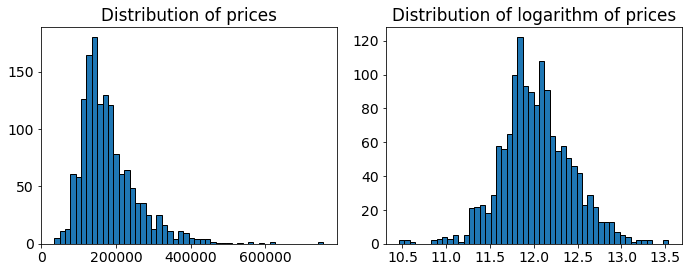

In [4]:
plt.figure()
plt.figure(figsize=(10,4));
plt.rcParams.update({'font.size': 14})
plt.subplot(121)
plt.hist(y, 50, edgecolor = 'k');
plt.title('Distribution of prices');
plt.subplot(122)
plt.hist(np.log(y), 50, edgecolor = 'k');
plt.title('Distribution of logarithm of prices');
plt.tight_layout()

The distribution of the prices is not Gaussian-like and therefore it will be easier for a model to predict logarithm of the house prices.

In [5]:
# Final score is calculated as root mean logarithmic error
def Score(model_prediction):
    Score = np.sqrt(np.mean((np.log(model_prediction) - np.log(y_cross))**2))
    return Score

Let's check Gradiend Boosting Regression and Ridge Linear Regression performance. 
The parameters of these models are chosen based on the validation set results.

# Gradiend Boosting Regression and Ridge Linear Regression

In [6]:
# ---- Ridge Regression 
from sklearn.linear_model import Ridge
clf = Ridge(alpha = 6).fit(X_train, np.log(y_train))
y_pred_Ridge_log = clf.predict(X_cross)
y_pred_Ridge = np.exp(y_pred_Ridge_log)

print ('Ridge regression score on the test set: ', Score(y_pred_Ridge))

Ridge regression score on the test set:  0.12979577869904974


In [7]:
# ---- Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators= X.shape[1]*4, learning_rate = 0.09, subsample= 0.8,
                                max_depth = 4, random_state=0, loss='ls').fit(X_train, np.log(y_train))
y_pred_Boost_log = est.predict(X_cross)
y_pred_Boost = np.exp(y_pred_Boost_log)

print ('Gradient boosting score on the test set: ', Score(y_pred_Boost))

Gradient boosting score on the test set:  0.12618222371827112


Read the file containing the results from the test set. This file was made public on Kaggle.

Let's see how the output of both models and why is combined model better than just one individual model.

<Figure size 432x288 with 0 Axes>

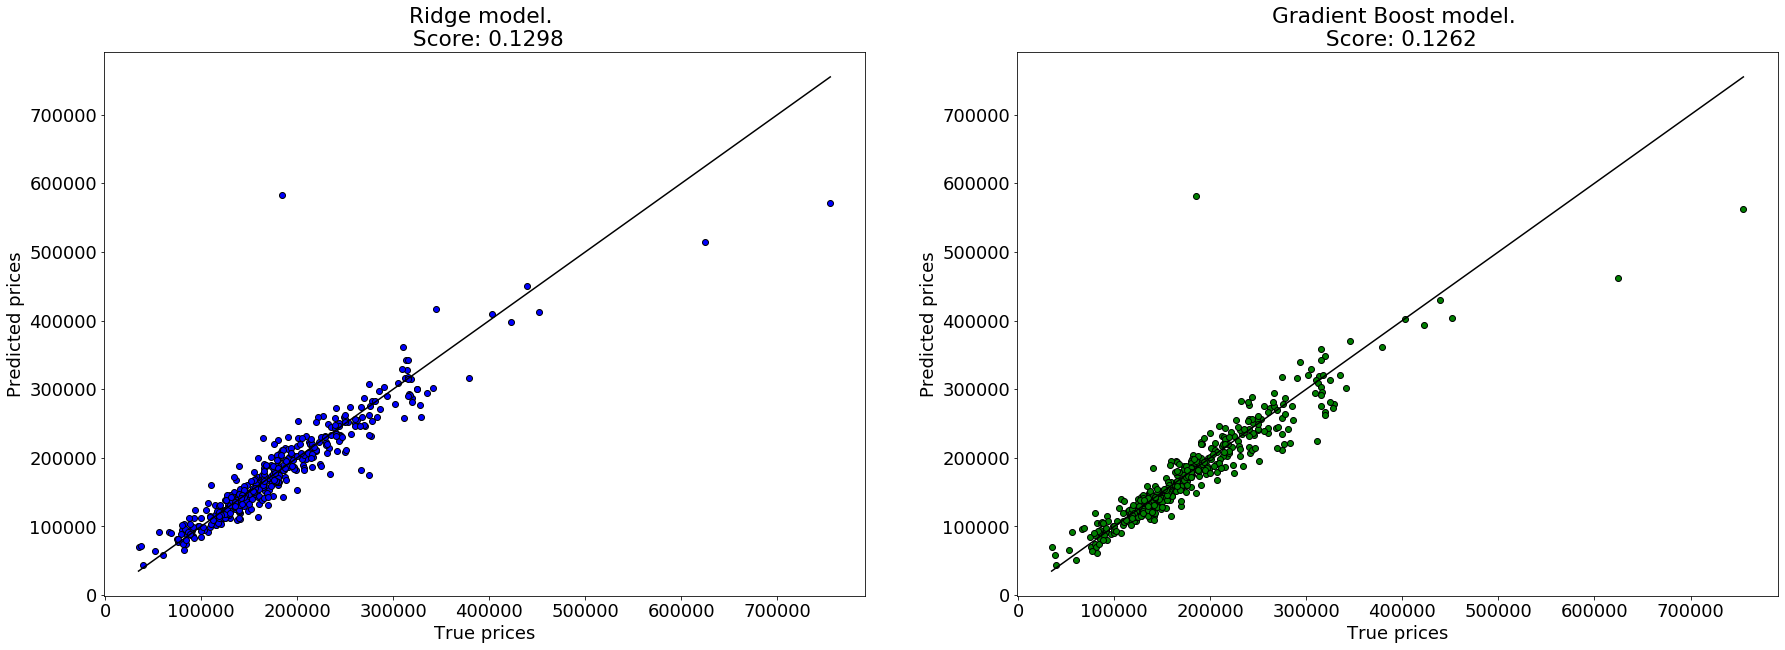

In [8]:
fig = plt.figure();
plt.figure(figsize=(30,10));
plt.rcParams.update({'font.size': 18})
plt.subplot(121);
plt.scatter(y_cross, y_pred_Ridge, color = 'b', edgecolor = 'k');
plt.plot([min(y_cross), max(y_cross)], [min(y_cross), max(y_cross)], color = 'k');
plt.title('Ridge model. \n Score: '+str(np.around(Score(y_pred_Ridge),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');
plt.subplot(122);
plt.scatter(y_cross, y_pred_Boost, color = 'g', edgecolor = 'k');
plt.plot([min(y_cross), max(y_cross)], [min(y_cross), max(y_cross)], color = 'k');
plt.title('Gradient Boost model. \n Score: '+str(np.around(Score(y_pred_Boost),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');
fig.tight_layout();

Downside of the both models is underestimate of the high prices.

# Support Vector Regression nad Random Forest

In [9]:
from sklearn.svm import SVR
sv_model = SVR(kernel='rbf',gamma='auto', C = 3, epsilon = 0.05).fit(X_train, np.log(y_train))
y_pred_SVR_log = sv_model.predict(X_cross)
y_pred_SVR = np.exp(y_pred_SVR_log)

In [10]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 200, random_state = 0, 
                               min_samples_split = 4, max_features= 0.6, n_jobs=-1).fit(X_train, np.log(y_train))
y_pred_RF_log = forest.predict(X_cross)
y_pred_RF = np.exp(y_pred_RF_log)

<Figure size 432x288 with 0 Axes>

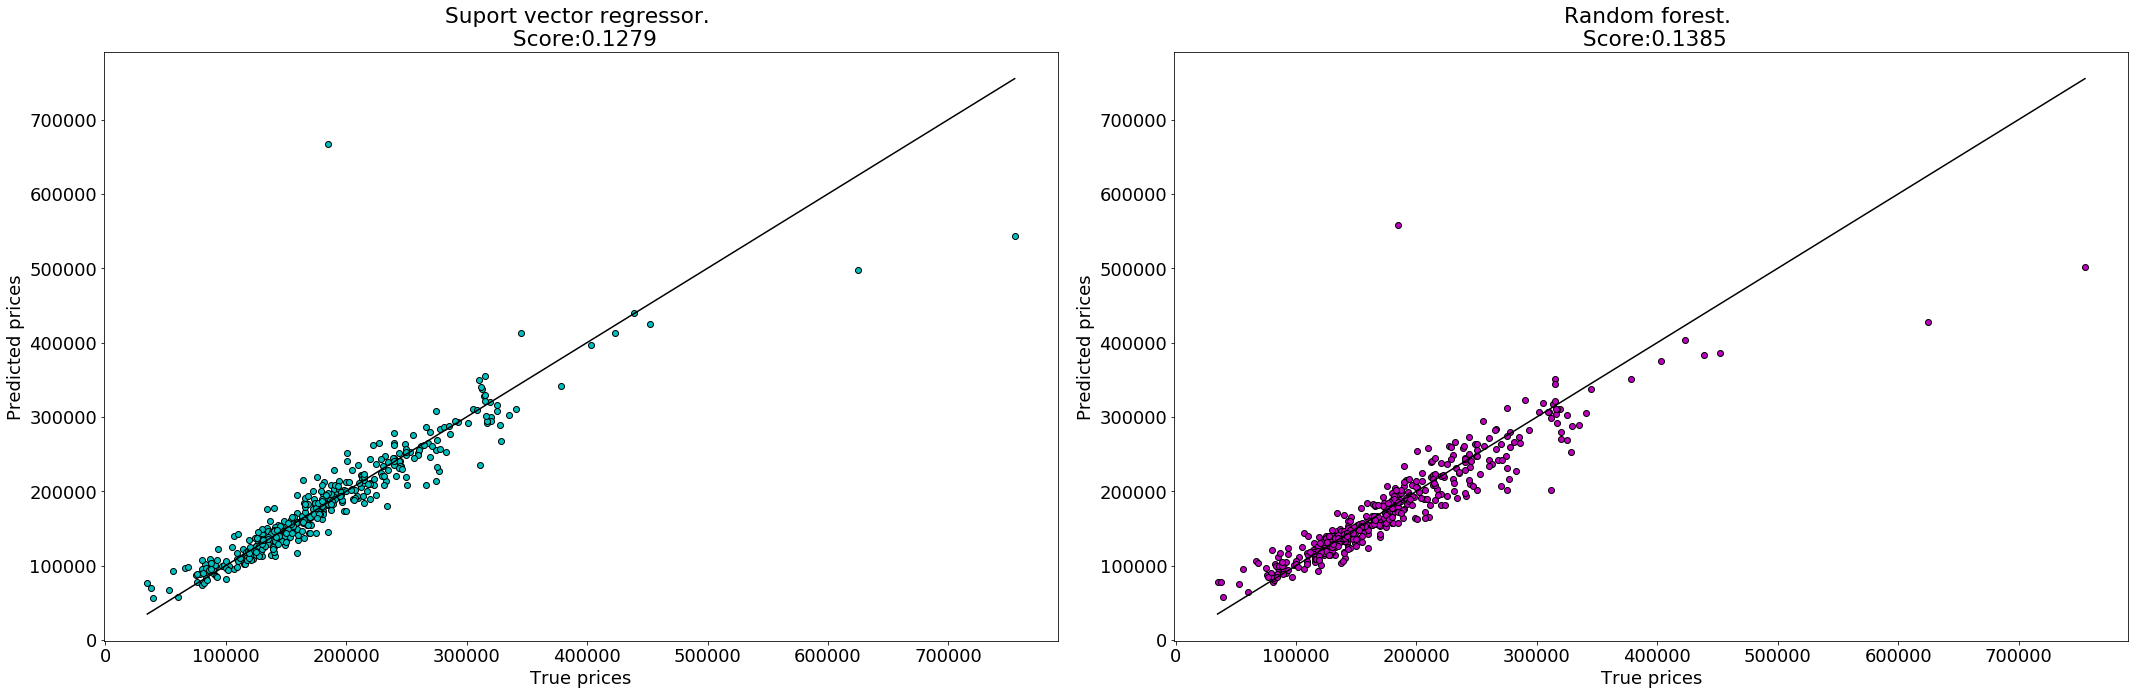

In [11]:
plt.figure();
plt.figure(figsize=(30,10));
plt.rcParams.update({'font.size': 18})
plt.subplot(121);
plt.scatter(y_cross, y_pred_SVR, color = 'c', edgecolor = 'k');
plt.plot([min(y_cross), max(y_cross)], [min(y_cross), max(y_cross)], color = 'k');
plt.title('Suport vector regressor. \n Score:' +str(np.around(Score(y_pred_SVR),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');
plt.subplot(122);
plt.scatter(y_cross, y_pred_RF, color = 'm', edgecolor = 'k');
plt.plot([min(y_cross), max(y_cross)], [min(y_cross), max(y_cross)], color = 'k');
plt.title('Random forest. \n Score:' +str(np.around(Score(y_pred_RF),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');
plt.tight_layout();

Now let's make a combined model taking into account 3 best performing models, namely: Ridge, GBR, SVR

In [12]:
all_scores = []
best_score = 0.2

for a in np.arange(0.0, 1, 0.05):
    rest = 1 - a
    for b in np.arange(0.0, rest, 0.05):
        c = rest - b
        y_pred = np.exp(a*y_pred_Boost_log + b*y_pred_Ridge_log + c*y_pred_SVR_log)
        if Score(y_pred) < best_score:
            combination = dict(a = np.around(a,2), b = np.around(b,2), c = np.around(c,2))
            best_score = Score(y_pred)
            
print('Boost fraction:', combination['a'])
print('Ridge fraction:', combination['b'])
print('SVR fraction:', combination['c'])

Boost fraction: 0.5
Ridge fraction: 0.2
SVR fraction: 0.3


In [13]:
y_3models = combination['a']*y_pred_Boost_log + combination['b']*y_pred_Ridge_log + combination['c'] * y_pred_SVR_log
print('Final Score of 3 models : ', Score(np.exp(y_3models)))

Final Score of 3 models :  0.12158100102298319


# Training on the full set of data

In [14]:
# ---- Ridge Regression 
clf = Ridge(alpha = 6).fit(X, np.log(y))
y_pred_Ridge_log_all = clf.predict(X_test)


# ---- Gradient Boosting
est = GradientBoostingRegressor(n_estimators= X.shape[1]*4, learning_rate = 0.09, subsample= 0.8,
                                max_depth = 4, random_state=0, loss='ls').fit(X, np.log(y))
y_pred_Boost_log_all = est.predict(X_test)


from sklearn.svm import SVR
sv_model = SVR(kernel='rbf',gamma='auto', C = 3, epsilon = 0.05).fit(X, np.log(y))
y_pred_SVR_log_all = sv_model.predict(X_test)

# --- Combined model
y_3models = combination['a']*y_pred_Boost_log_all + combination['b']*y_pred_Ridge_log_all + combination['c']* y_pred_SVR_log_all

Now read the results of the test set. These results were dowloaded from the Kaggle Notebook: Perfect Score for Evaluation Purposes.

In [15]:
y_test = pd.read_csv('true_results.csv')
y_test = y_test.iloc[:,1].values

In [16]:
print('Final Score of 3 models on the True results: ', np.sqrt(np.mean((y_3models - np.log(y_test))**2)))

Final Score of 3 models on the True results:  0.11586519191601055


# XGBoost

I have already used GradientBoostingRegressor() class from sklearn, however XGBoost enables also regularization of the trees.

In [17]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.8, gamma = 0.3, 
                             learning_rate=0.08, max_depth = 3, 
                             min_child_weight = 2, n_estimators = 500,
                             reg_alpha = 1, reg_lambda = 3,
                             subsample=0.8, random_state = 5, nthread = -1)


model_xgb.fit(X_train, (y_train))
y_pred_xgb = model_xgb.predict(X_cross)
y_pred_xgb_log = np.log(y_pred_xgb)

print ('XGBoost score on the cross set: ', Score(y_pred_xgb))

XGBoost score on the cross set:  0.12825366892861637


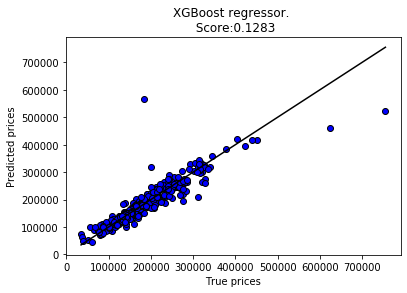

In [18]:
fig = plt.figure();
plt.rcParams.update({'font.size': 10})
plt.scatter(y_cross, y_pred_xgb, color = 'b', edgecolor = 'k');
plt.plot([min(y_cross), max(y_cross)], [min(y_cross), max(y_cross)], color = 'k');
plt.title('XGBoost regressor. \n Score:' +str(np.around(Score(y_pred_xgb),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');

In [19]:
all_scores = []
best_score = 0.2

for a in np.arange(0.0, 1, 0.05):
    rest1 = 1 - a
    for b in np.arange(0.0, rest1, 0.05):
        rest2 = rest1 - b
        for c in np.arange(0.0, rest2, 0.05):
            d = rest2 - c
            y_pred = np.exp(a*y_pred_Boost_log + b*y_pred_Ridge_log + c*y_pred_SVR_log + d*y_pred_xgb_log)
            if Score(y_pred) < best_score:
                combination = dict(a = np.around(a,2), b = np.around(b,2), c = np.around(c,2), d = np.around(d,2))
                best_score = Score(y_pred)
            
print('Boost fraction:', combination['a'])
print('Ridge fraction:', combination['b'])
print('SVR fraction:', combination['c'])
print('XGBoost fraction:', combination['d'])

y_4models = combination['a']*y_pred_Boost_log + combination['b']*y_pred_Ridge_log + combination['c']* y_pred_SVR_log + combination['d']*y_pred_xgb_log
print('Final Score of 4 models on Cross set : ', Score(np.exp(y_4models)))

Boost fraction: 0.45
Ridge fraction: 0.2
SVR fraction: 0.2
XGBoost fraction: 0.15
Final Score of 4 models on Cross set :  0.12133115292159989


In [20]:
model_xgb.fit(X, y)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_xgb_log_all = np.log(y_pred_xgb)

In [21]:
print('Final Score of XGBoost model on the Test set: ', np.sqrt(np.mean((y_pred_xgb_log_all - np.log(y_test))**2)))

# --- Combined model
y_4models = combination['a']*y_pred_Boost_log_all + combination['b']*y_pred_Ridge_log_all + combination['c']* y_pred_SVR_log_all + combination['d']*y_pred_xgb_log_all

print('Final Score of 4 models on the Test set: ', np.sqrt(np.mean((y_4models - np.log(y_test))**2)))

Final Score of XGBoost model on the Test set:  0.12454564048252952
Final Score of 4 models on the Test set:  0.11579498538416555


<h3> Saving output for submission </h3>

In [22]:
Data_all_test = pd.read_csv("test.csv")
ID_test = Data_all_test.iloc[:, 0]
MySubmision = pd.concat([ID_test, pd.DataFrame(np.exp(y_3models))], axis=1)
MySubmision.columns = ['Id', 'SalePrice']
MySubmision.to_csv('MySubmision_Combination_4Models.csv', index=False)

The model reaches Score of 0.119 at the Kaggle board because leaderboard is calculated with approximately 50% of the test data. The final results will be based on the other 50%, so the final standings may be different.

# A Deep Learning model

Let's now build a DL model. The model will have sigmoid activation function in the last layer, therefore value of y (Prices)
will be rescaled to the range [0, 1]

In [23]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

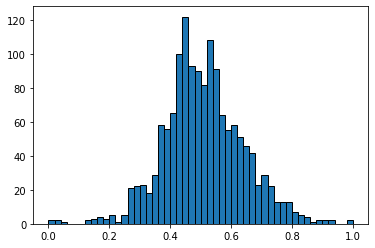

In [24]:
scaler = MinMaxScaler(feature_range = (0,1))
Y_scaled = scaler.fit_transform(np.log(y).reshape((-1,1)))

plt.hist(Y_scaled, 50, edgecolor = 'k');

I will define a model with 3 hidden layers, 2 of which will have 2,292 hidden units (number of features * 6) and the last layer has 191 units. As regularization Dropout and kernel L2 regularization are used.

In [25]:
n_features = X.shape[1]
input_dimension = X_train.shape[1]

prices_model = Sequential()
prices_model.add(Dense(units = n_features*6, activation = 'relu', input_dim = input_dimension, 
                      kernel_initializer = GlorotUniform(seed = 0),
                      kernel_regularizer = l2(l=5e-4)))
prices_model.add(Dropout(0.4))

prices_model.add(Dense(units = n_features*6, activation = 'relu',
                      kernel_regularizer = l2(l=5e-4)))
prices_model.add(Dropout(0.4))

prices_model.add(Dense(units =  n_features//2 , activation = 'relu',
                      kernel_regularizer = l2(l=5e-4)))
prices_model.add(Dropout(0.2))

prices_model.add(Dense(units = 1, activation = 'sigmoid'))

Adam optimizer is used with a learning rate of 0.0001 and the loss function is binary crossentropy.

In [26]:
opt = Adam(learning_rate = 0.0001)
prices_model.compile(optimizer = opt, loss = 'binary_crossentropy')
history = prices_model.fit(X, Y_scaled, epochs = 150)

Epoch 1/150
46/46 [==============================] - 5s 112ms/step - loss: 2.1958
Epoch 2/150
46/46 [==============================] - 5s 113ms/step - loss: 1.9423
Epoch 3/150
46/46 [==============================] - 5s 118ms/step - loss: 1.7204
Epoch 4/150
46/46 [==============================] - 6s 140ms/step - loss: 1.5318
Epoch 5/150
46/46 [==============================] - 6s 127ms/step - loss: 1.3754
Epoch 6/150
46/46 [==============================] - 6s 138ms/step - loss: 1.2472
Epoch 7/150
46/46 [==============================] - 6s 136ms/step - loss: 1.1422
Epoch 8/150
46/46 [==============================] - 6s 128ms/step - loss: 1.0575
Epoch 9/150
46/46 [==============================] - 6s 129ms/step - loss: 0.9885
Epoch 10/150
46/46 [==============================] - 5s 114ms/step - loss: 0.9329
Epoch 11/150
46/46 [==============================] - 6s 120ms/step - loss: 0.8879
Epoch 12/150
46/46 [==============================] - 5s 118ms/step - loss: 0.8510
Epoch 13/150


46/46 [==============================] - 5s 115ms/step - loss: 0.6620
Epoch 100/150
46/46 [==============================] - 5s 118ms/step - loss: 0.6621
Epoch 101/150
46/46 [==============================] - 5s 113ms/step - loss: 0.6619
Epoch 102/150
46/46 [==============================] - 5s 112ms/step - loss: 0.6623
Epoch 103/150
46/46 [==============================] - 5s 119ms/step - loss: 0.6622
Epoch 104/150
46/46 [==============================] - 5s 111ms/step - loss: 0.6621
Epoch 105/150
46/46 [==============================] - 5s 112ms/step - loss: 0.6620
Epoch 106/150
46/46 [==============================] - 6s 124ms/step - loss: 0.6620
Epoch 107/150
46/46 [==============================] - 5s 118ms/step - loss: 0.6619
Epoch 108/150
46/46 [==============================] - 5s 113ms/step - loss: 0.6620
Epoch 109/150
46/46 [==============================] - 5s 117ms/step - loss: 0.6620
Epoch 110/150
46/46 [==============================] - 5s 111ms/step - loss: 0.6620
Epoch 

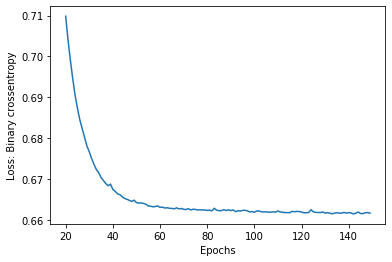

In [27]:
plt.figure()
plt.plot(np.arange(20, 150, 1), history.history['loss'][20:])
plt.xlabel('Epochs')
plt.ylabel('Loss: Binary crossentropy');

In [28]:
y_pred_DL_test = prices_model.predict(X_test)
y_pred_DL_train = prices_model.predict(X)

y_pred_DL_test = scaler.inverse_transform(y_pred_DL_test)
y_pred_DL_train = scaler.inverse_transform(y_pred_DL_train)

y_pred_DL_test = np.exp(y_pred_DL_test).reshape(-1,)
y_pred_DL_train = np.exp(y_pred_DL_train).reshape(-1,)

print('Calculated TRAIN score: ', np.sqrt(np.mean((np.log(y) - np.log(y_pred_DL_train))**2)))
print('Calculated TEST score: ', np.sqrt(np.mean((np.log(y_test) - np.log(y_pred_DL_test))**2)))

Calculated TRAIN score:  0.07019336899771716
Calculated TEST score:  0.1264424605618918


<Figure size 432x288 with 0 Axes>

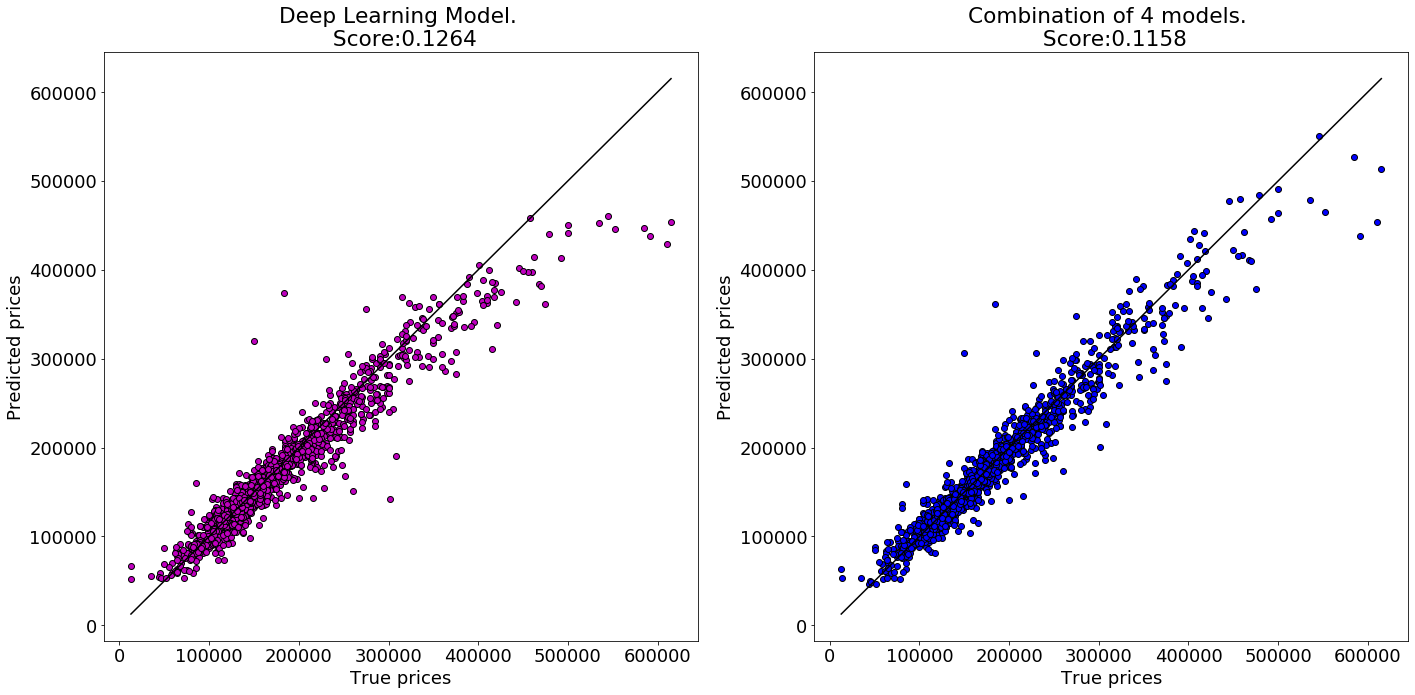

In [29]:
plt.figure()
plt.figure(figsize=(20,10));
plt.rcParams.update({'font.size': 18})
plt.subplot(121)
plt.scatter(y_test, y_pred_DL_test, color = 'm', edgecolor = 'k');
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'k');
plt.title('Deep Learning Model. \n Score:' +str(np.around(np.sqrt(np.mean((np.log(y_test) - np.log(y_pred_DL_test))**2)),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');

plt.subplot(122)
plt.scatter(y_test, np.exp(y_4models), color = 'b', edgecolor = 'k');
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'k');
plt.title('Combination of 4 models. \n Score:' +str(np.around(np.sqrt(np.mean((y_4models - np.log(y_test))**2)),4)));
plt.xlabel('True prices');
plt.ylabel('Predicted prices');
plt.tight_layout()

Now I will blend Deep Learning predictions with the predictions from 4 different models. 

In [33]:
y_total = 0.1 * y_pred_DL_test + 0.9 * np.exp(y_4models)
print('Final Score of 4 models and DL model on Test set: ', np.sqrt(np.mean((np.log(y_total) - np.log(y_test))**2)))

Final Score of 4 models and DL model on Test set:  0.11570940926246198


<h3> Saving output for submission </h3>

In [34]:
Data_all_test = pd.read_csv("test.csv")
ID_test = Data_all_test.iloc[:, 0]
MySubmision = pd.concat([ID_test, pd.DataFrame(y_total)], axis=1)
MySubmision.columns = ['Id', 'SalePrice']
MySubmision.to_csv('MySubmision_Combination_All_Models.csv', index=False)